In [ ]:
# default_exp models.nbeats

In [ ]:
# hide
import sys

sys.path.append("..")

# N-Beats model

> A basic architecture for time series forecasting.


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

In [ ]:
torch.linspace(-10,5,15)

tensor([-10.0000,  -8.9286,  -7.8571,  -6.7857,  -5.7143,  -4.6429,  -3.5714,
         -2.5000,  -1.4286,  -0.3571,   0.7143,   1.7857,   2.8571,   3.9286,
          5.0000])

In [ ]:
# export

def linspace(lookback, horizon):
    lin_space = torch.linspace(
        -lookback, horizon, lookback + horizon
    )
    b_ls = lin_space[:lookback]
    f_ls = lin_space[lookback:]
    return b_ls, f_ls


In [ ]:
# export
class GenericBlock(Module):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False
    ):
        ps = ifnone(ps, L([0])*len(layers))
        sizes = [lookback] + layers
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn, p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps, actns))]
        self.layers = nn.Sequential(*_layers)
        
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinBnDrop(layers[-1], thetas_dim).to(device)
        else:
            self.theta_b_fc = LinBnDrop(layers[-1], thetas_dim).to(device)
            self.theta_f_fc = LinBnDrop(layers[-1], thetas_dim).to(device)
        
        self.backcast_fc = nn.Linear(thetas_dim, lookback).to(device)
        self.forecast_fc = nn.Linear(thetas_dim, horizon).to(device)
        
        b,f = linspace(lookback, horizon)
        self.backcast_linspace, self.forecast_linspace = Variable(b, requires_grad=False).to(device), Variable(f, requires_grad=False).to(device)
        self.to(device)
        
    def forward(self, x):
        # general
        x = self.layers(x)
        backcast = self.backcast_fc(self.theta_b_fc(x))
        forecast = self.forecast_fc(self.theta_f_fc(x))
        return backcast, forecast
    


In [ ]:
mdl = GenericBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
backcast, forecast = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(backcast.shape, (64,100))
test_eq(forecast.shape, (64,10))

In [ ]:
# export

def seasonality_model(thetas, t):
    p = thetas.size()[-1]
    assert p < 10, "thetas_dim is too big."
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = [torch.cos(2 * np.pi * i * t)[None,:] for i in range(p1)] # H/2-1
    s2 = [torch.sin(2 * np.pi * i * t)[None,:] for i in range(p2)]
    S = torch.cat([*s1, *s2])
    return thetas.mm(S)

class SeasonalityBlock(Module):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False
    ):
        ps = ifnone(ps, L([0])*len(layers))
        sizes = [lookback] + layers
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn, p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps, actns))]
        self.layers = nn.Sequential(*_layers)
        
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinBnDrop(layers[-1], thetas_dim).to(device)
        else:
            self.theta_b_fc = LinBnDrop(layers[-1], thetas_dim).to(device)
            self.theta_f_fc = LinBnDrop(layers[-1], thetas_dim).to(device)
            
        b,f = linspace(lookback, horizon)
        self.backcast_linspace, self.forecast_linspace = Variable(b, requires_grad=False).to(device), Variable(f, requires_grad=False).to(device)
        self.to(device)
        
    def forward(self, x):
        # season
        x = self.layers(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace)
        return backcast, forecast
    

In [ ]:
mdl = SeasonalityBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
backcast, forecast = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(backcast.shape, (64,100))
test_eq(forecast.shape, (64,10))

In [ ]:
# export
def trend_model(thetas, t):
    p = thetas.size()[-1]
    assert p <= 4, "thetas_dim is too big."
    a = [torch.pow(t, i)[None,:] for i in range(p)]
    T = torch.cat(a).float()
    return thetas.mm(T)

class TrendBlock(Module):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False
    ):
        ps = ifnone(ps, L([0])*len(layers))
        sizes = [lookback] + layers
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn, p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps, actns))]
        self.layers = nn.Sequential(*_layers)
        
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinBnDrop(layers[-1], thetas_dim)
        else:
            self.theta_b_fc = LinBnDrop(layers[-1], thetas_dim)
            self.theta_f_fc = LinBnDrop(layers[-1], thetas_dim)
            
        b,f = linspace(lookback, horizon)
        self.backcast_linspace, self.forecast_linspace = Variable(b, requires_grad=False).to(device), Variable(f, requires_grad=False).to(device)
        self.to(device)
        
    def forward(self, x):
        # trend
        x = self.layers(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace)
        return backcast, forecast
    

In [ ]:
mdl = TrendBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
backcast, forecast = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(backcast.shape, (64,100))
test_eq(forecast.shape, (64,10))

In [ ]:
# export
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F


class NBeatsNet(Module):
    SEASONALITY_BLOCK = "seasonality"
    TREND_BLOCK = "trend"
    GENERIC_BLOCK = "generic"

    def __init__(
        self,
        device,
        stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dims=(2, 8),
        share_weights_in_stack=True,
        hidden_layer_units= [200,100],
    ):
        super(NBeatsNet, self).__init__()
        self.horizon = horizon
        self.lookback = lookback
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dims
        self.device = device
        self._str = "| N-Beats\n"
        stacks = OrderedDict()
        for stack_id in range(len(self.stack_types)):
            stacks[self.stack_types[stack_id] +str(stack_id)] = self.create_stack(stack_id)
        self.stacks = nn.Sequential(stacks)
    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        self._str += f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})\n"
        
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units,
                    self.thetas_dim[stack_id],
                    self.device,
                    self.lookback,
                    self.horizon,
                )
            self._str += f"     | -- {block}\n"
            blocks.append(block)
            
        return nn.Sequential(*blocks)

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def forward(self, backcast):
        backcast = backcast.view([-1,backcast.shape[-1]])
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
                
        return forecast[:,None,:]



In [ ]:
net = NBeatsNet(stack_types=[NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK],
                horizon=14,
                thetas_dims=[7, 8],
                nb_blocks_per_stack=3,
                lookback=140,
                hidden_layer_units=[2],
                share_weights_in_stack=True,
                device=torch.device('cuda'))

In [ ]:
# export
from fastai2.basics import *
from fastseq.all import *


@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataBunch, output_channels=None, metrics=None, **kwargs):
    "Build a N-Beats style learner"    
    model = NBeatsNet(
        device = dbunch.train_dl.device,
        horizon = dbunch.train_dl.horizon,
        lookback = dbunch.train_dl.lookback, 
        **kwargs
       )
    model = model.to(dbunch.train_dl.device)
    
    learn = Learner(dbunch, model, loss_func=smape, opt_func= Adam, metrics=L(metrics)+L(mae))
    return learn

In [ ]:
path = untar_data(URLs.m4_daily)
data = TSDataBunch.from_folder(path, horizon = 14, lookback = 128, bs = 16, nrows=4, device = 'cuda')

Need to pad 2/4 time series due to length.
Need to pad 1/4 time series due to length.
Train:1604; Valid: 131; Test 4


In [ ]:
learn = nbeats_learner(data)

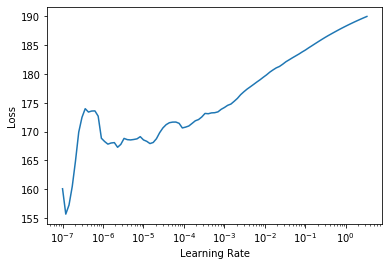

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

In [ ]:
learn.fit(1, 1e-4)

epoch,train_loss,valid_loss,mae,time
0,176.975815,186.526917,18.018333,00:01


In [ ]:
learn.get_preds(dl=learn.dbunch.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

RuntimeError: shape '[96, -1]' is invalid for input of size 1

In [ ]:
# hide

print(learn.summary())

NBeatsNet (Input shape: ['64 x 1 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 128             256        True      
________________________________________________________________
Linear               64 x 200             25,600     True      
________________________________________________________________
ReLU                 64 x 200             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 2               200        True      
________________________________________________________

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 07_interpret.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 10_models.nbeats.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
